## Import Modules

In [1]:
import cv2, os
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## Define Class

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

## Download & load pretrained weights

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


## 1) Person
### Load image data

In [4]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/박보영1.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(763, 610, 3)


### run model

In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(763, 610, 3) (513, 410, 3) 15


### Define Labels

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

### Define Mask

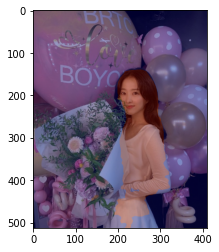

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### resize to the shape of original picture

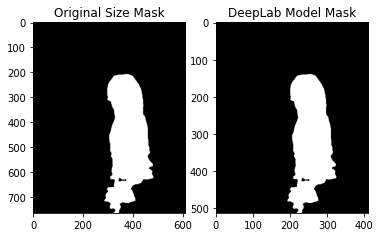

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

### blur picture for the background

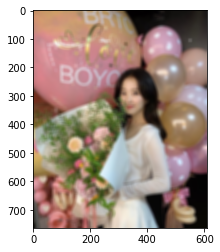

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

### get blurred background

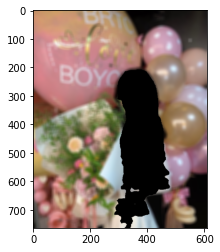

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### Concatenate original picture and blurred background

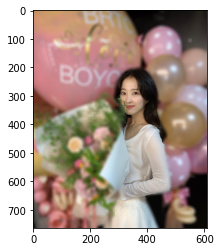

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Try other pictures

박보영2
(960, 640, 3)
(960, 640, 3) (513, 342, 3) 16


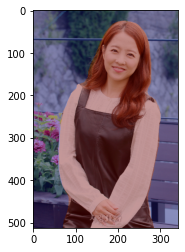

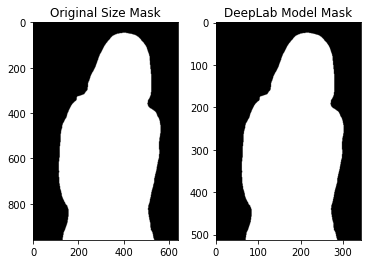

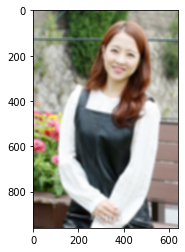

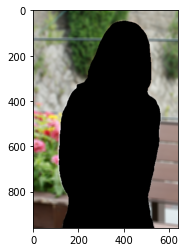

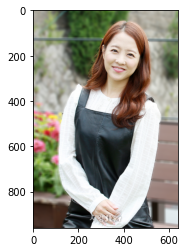

박보영3
(448, 568, 3)
(448, 568, 3) (404, 513, 3) 16


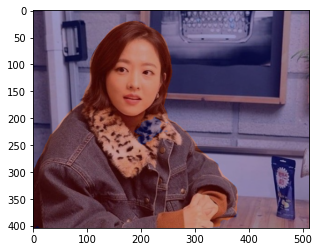

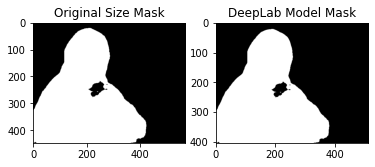

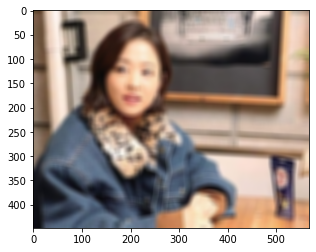

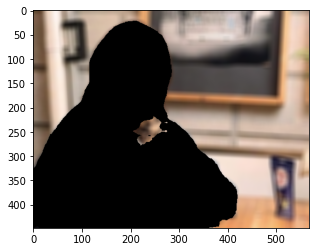

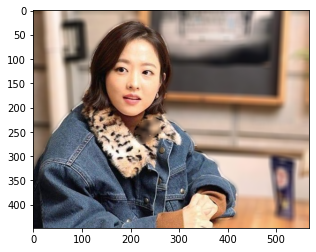

In [12]:
### get image path
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
image_files= ['박보영2.jpg', '박보영3.png']
for file_name in image_files:
    print(file_name.split('.')[0])
    img_path= os.path.join(img_dir, file_name)
    img_orig = cv2.imread(img_path) 
    print (img_orig.shape)
    ### run model
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    ### Define Mask
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    ### resize to the shape of original picture
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    ### blur picture for the background
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    ### get blurred background
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    ### Concatenate original picture and blurred background
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

## 2) Cat

cat1
(450, 800, 3)
(450, 800, 3) (288, 513, 3) 8


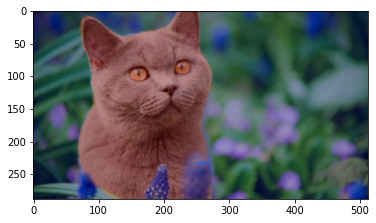

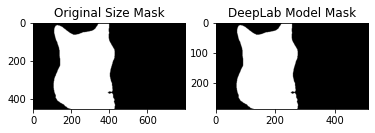

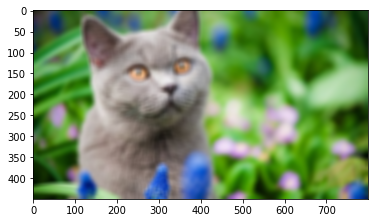

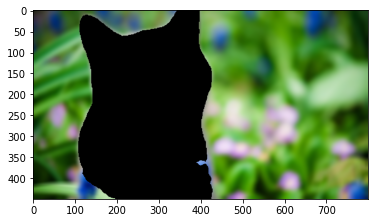

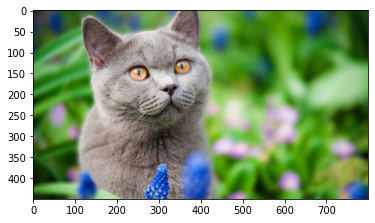

cat2
(450, 800, 3)
(450, 800, 3) (288, 513, 3) 8


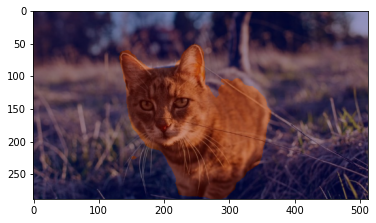

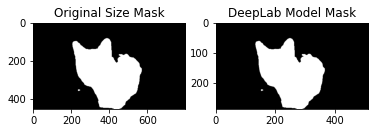

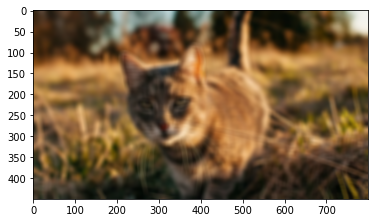

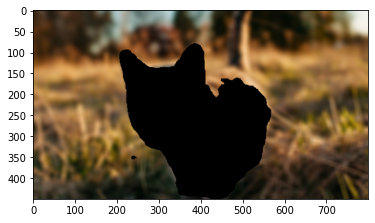

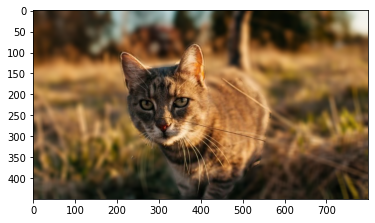

In [13]:
### get image path
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
image_files= ['cat1.jpg', 'cat2.jpg']
for file_name in image_files:
    print(file_name.split('.')[0])
    img_path= os.path.join(img_dir, file_name)
    img_orig = cv2.imread(img_path) 
    print (img_orig.shape)
    ### run model
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    ### Define Mask
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    ### resize to the shape of original picture
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()
    ### blur picture for the background
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    ### get blurred background
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    ### Concatenate original picture and blurred background
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

## Chroma Key

### 1) Try Green Chroma Key
##### generate green background and concatenate it with detected person

박보영3
(448, 568, 3)
(448, 568, 3) (404, 513, 3) 16


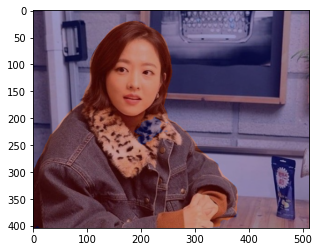

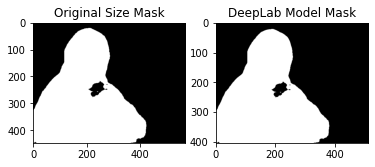

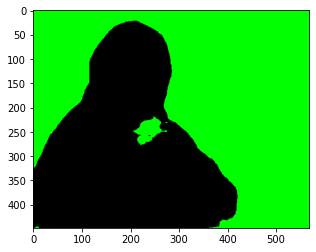

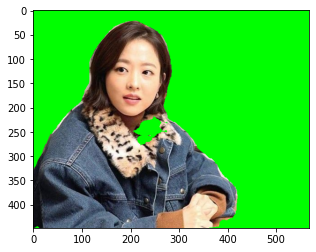

In [14]:
### get image path
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
file_name= '박보영3.png' #, '박보영1.jpg',박보영2.jpg', 박보영3.png'
print(file_name.split('.')[0])
img_path= os.path.join(img_dir, file_name)
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

### run model
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

### Define Mask
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### resize to the shape of original picture
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')
plt.show()

image_g= np.full(img_orig.shape, (0, 255, 0), dtype=np.uint8) ### give green backgroundd        
plt.show()

### get blurred background
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(image_g, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### Concatenate original picture and blurred background
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 2) Add Different Background

bg1
(435, 580, 3)


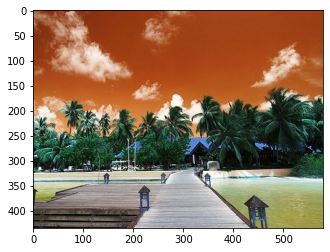

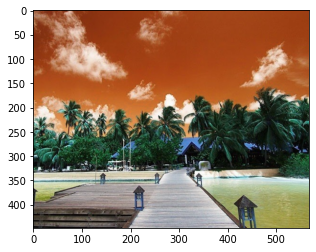

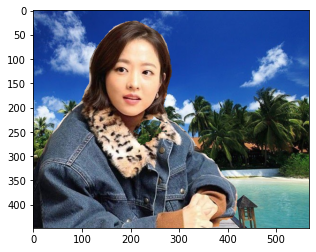

In [15]:
### get image path
img_dir = os.getenv('HOME')+'/aiffel/human_segmentation/images'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
file_name= 'bg1.png'
print(file_name.split('.')[0])

bg_path= os.path.join(img_dir, file_name)
bg_orig = cv2.imread(bg_path) 
# bg_orig = cv2.cvtColor(bg_orig, cv2.COLOR_BGR2RGB) 
print (bg_orig.shape)
plt.imshow(bg_orig)
plt.show()

# bg_= cv2.resize(bg_orig, dsize= (img_orig.shape[0], img_orig.shape[1]), interpolation=cv2.INTER_AREA)
bg_ = cv2.resize(bg_orig, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
plt.imshow(bg_)
plt.show()
### Concatenate original picture and blurred background
img_concat = np.where(img_mask_color==255, img_orig, bg_)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 회고
### Project summary
- tensorflow1 & tensorflow2 (tf.compat.v1 사용)
- DeepLab 모델 사용
- pretrained weight 사용

#### 1) 사람 사진에서 배경을 블러처리: 
    - 사진에서 사람을 detect & segmentation 후 블러 처리한 배경을 합성
    - 라벨 no.15
#### 2) 고양이 사진에서 배경을 블러처리: 
    - 사진에서 고양이를 detect & segmentation 후 블러 처리한 배경을 합성
    - 라벨 no.8
#### 3) 크로마키
     - 사진에서 사람을 detect & segmentation 후 다른 배경을 합성
         1) 초록 이미지를 배경으로 합성하여 segment 된 부분을 명확히 확인
         2) segmented 된 사람부분을 다른 배경과 합성
     - 라벨 no.15


###  Process 
#### 1) DeepLabModel 와 pretrained weight 사용하여 모델 load
#### 2) Define 된 Label 에서 찾고자 하는 물체를 선정하여 물체 인식, segment 하여 Mask 이미지 생성
#### 3) 원본 이미지를 블러처리하여 물체부분을 지움
#### 4) 블러 처리한 배경과 본 이미지을 합성하여 물체는 원본값, 배경은 블러 처리된 이미지 값으로 표현


### Issues
#### 이미지에서 detect 를 부분부분 명확하게 하지 못하는 부분이 있음.
- 사람의 사진에서는 특히 옷의 주름부분이나 머리카락 등 애매한 부분, 명암/색상차이 혹은 그림자나 옷 문양으로 인해 인식하지 못하는 부분이 있다.
- 첫번째 사진의 경우 사람이 꽃다발을 들고 있는 부분에서, 사람 앞에 있는 물체는 명확히 사람이 아닌 것으로 잘 인식하였다. 
- 첫번째 고양이 사진에서는 고양이 앞의 꽃을 한개는 배경으로 인식하였으나, 한개는 고양이의 일부분으로 잘못 인식하여 블러처리가 되지 않았다.
- 두번째 고양이 사진에서는 배경사진과 색상이 비슷하여 특히 꼬리 부분을 인식하지 못하여 배경과 함께 블러처리 되었다.
- 사람의 경우, 초록색 배경으로 합성하여 확인 했을 때, 사람의 일부분이 배경으로 인식된 것을 보다 명확히 볼 수 있었으며, 다른 배경과 합성할 때 잘못 합성된 것을 확인할 수 있었다.
